In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
folder = '/content/drive/MyDrive/FMC_Data/M-B_data_by_purpose_domestic_residents'
files = [
    'purpose_1_with_OD_indicators.csv'
]

# Combine files
dfs = [pd.read_csv(os.path.join(folder, f)) for f in files]
df = pd.concat(dfs, ignore_index=True)

In [6]:
df.columns

Index(['O_ADMDONG_CD', 'D_ADMDONG_CD', 'ST_TIME_CD', 'FNS_TIME_CD',
       'IN_FORN_DIV_NM', 'FORN_CITIZ_NM', 'MOVE_PURPOSE', 'MOVE_DIST',
       'MOVE_TIME', 'CNT', 'ETL_YMD', 'date', 'O_Seoul', 'D_Seoul', 'O_SMA',
       'D_SMA'],
      dtype='object')

In [3]:
# Setting to use a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
# Setting to Use a High-RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 185.7 gigabytes of available RAM

You are using a high-RAM runtime!


In [20]:
# Load dataset
folder = '/content/drive/MyDrive/FMC_Data/M-B_data_by_purpose_domestic_residents'

#@title non-working trip dataset
files = [
    'purpose_2_with_OD_indicators.csv',
    'purpose_4_with_OD_indicators.csv',
    'purpose_5_with_OD_indicators.csv',
    'purpose_6_with_OD_indicators.csv',
    'purpose_7_with_OD_indicators.csv'
]

# Combine files
dfs = [pd.read_csv(os.path.join(folder, f)) for f in files]
df = pd.concat(dfs, ignore_index=True)

In [21]:
# 1. Filter the two subsamples
df_seoul_to_seoul = df[(df['O_Seoul'] == 1) & (df['D_Seoul'] == 1)]
df_to_seoul = df[df['D_Seoul'] == 1]

def trip_time_distribution(df_sub, bins=[15, 30]):
    """
    Returns the weighted frequency distribution for given bins (in minutes).
    """
    total_trips = df_sub['CNT'].sum()
    result = {}
    prev_bin = 0
    for bin_max in bins:
        mask = (df_sub['MOVE_TIME'] > prev_bin) & (df_sub['MOVE_TIME'] <= bin_max)
        count = df_sub.loc[mask, 'CNT'].sum()
        result[f'Within {bin_max} min'] = count / total_trips * 100  # as percentage
        prev_bin = bin_max
    # Also, optionally, trips longer than last bin
    mask = df_sub['MOVE_TIME'] > bins[-1]
    count = df_sub.loc[mask, 'CNT'].sum()
    result[f'Over {bins[-1]} min'] = count / total_trips * 100
    return result

# 2. Calculate distributions
seoul_to_seoul_dist = trip_time_distribution(df_seoul_to_seoul)
to_seoul_dist = trip_time_distribution(df_to_seoul)

print("Seoul to Seoul nonworking-trip time distribution (%):")
for k, v in seoul_to_seoul_dist.items():
    print(f"{k}: {v:.2f}%")

print("\nEverywhere to Seoul nonworking-trip time distribution (%):")
for k, v in to_seoul_dist.items():
    print(f"{k}: {v:.2f}%")

Seoul to Seoul nonworking-trip time distribution (%):
Within 15 min: 43.09%
Within 30 min: 18.75%
Over 30 min: 38.16%

Everywhere to Seoul nonworking-trip time distribution (%):
Within 15 min: 36.79%
Within 30 min: 16.89%
Over 30 min: 46.31%


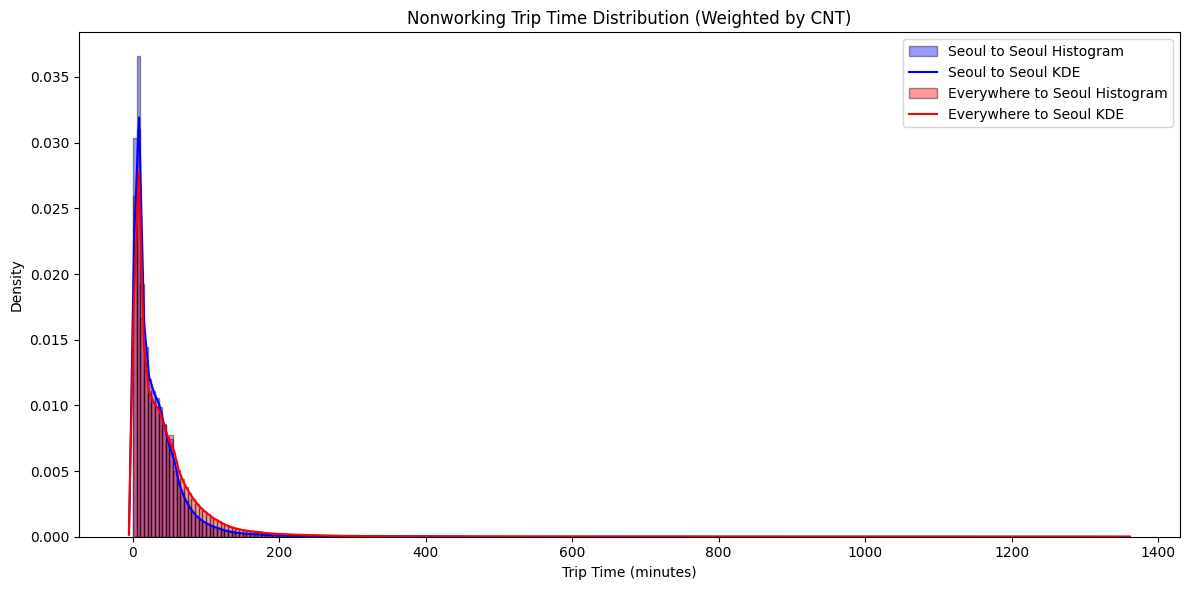

In [22]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# df_seoul_to_seoul = df[(df['O_Seoul'] == 1) & (df['D_Seoul'] == 1)]
# df_to_seoul = df[df['D_Seoul'] == 1]

def plot_weighted_hist_kde(df_sub, label, color, bins):
    # Histogram
    plt.hist(
        df_sub['MOVE_TIME'],
        bins=bins,
        weights=df_sub['CNT'],
        alpha=0.4,
        label=f"{label} Histogram",
        color=color,
        density=True,
        edgecolor='black'
    )

    # KDE
    sns.kdeplot(
        x=df_sub['MOVE_TIME'],
        weights=df_sub['CNT'],
        bw_adjust=1,
        label=f"{label} KDE",
        color=color
    )

# Set up bins before plotting
max_time = max(df_seoul_to_seoul['MOVE_TIME'].max(), df_to_seoul['MOVE_TIME'].max())
bins = np.arange(0, max_time + 5, 5)

plt.figure(figsize=(12, 6))
plot_weighted_hist_kde(df_seoul_to_seoul, 'Seoul to Seoul', 'blue', bins)
plot_weighted_hist_kde(df_to_seoul, 'Everywhere to Seoul', 'red', bins)

plt.xlabel('Trip Time (minutes)')
plt.ylabel('Density')
plt.title('Nonworking Trip Time Distribution (Weighted by CNT)')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
max_move_time_seoul_to_seoul = df_seoul_to_seoul['MOVE_TIME'].max()
max_move_time_to_seoul = df_to_seoul['MOVE_TIME'].max()

print("Maximum MOVE_TIME in Seoul to Seoul trips:", max_move_time_seoul_to_seoul)
print("Maximum MOVE_TIME in Everywhere to Seoul trips:", max_move_time_to_seoul)

Maximum MOVE_TIME in Seoul to Seoul trips: 1356.135
Maximum MOVE_TIME in Everywhere to Seoul trips: 1356.135


In [25]:
# Calculate the 99th percentile for each dataset
threshold_seoul_to_seoul = df_seoul_to_seoul['MOVE_TIME'].quantile(0.95)
threshold_to_seoul = df_to_seoul['MOVE_TIME'].quantile(0.95)

# Filter out rows above the threshold
df_seoul_to_seoul_trimmed = df_seoul_to_seoul[df_seoul_to_seoul['MOVE_TIME'] <= threshold_seoul_to_seoul]
df_to_seoul_trimmed = df_to_seoul[df_to_seoul['MOVE_TIME'] <= threshold_to_seoul]

print(f"95th percentile MOVE_TIME in Seoul to Seoul: {threshold_seoul_to_seoul}")
print(f"95th percentile MOVE_TIME in Everywhere to Seoul: {threshold_to_seoul}")
print(f"Rows before trimming (Seoul-Seoul): {len(df_seoul_to_seoul)}")
print(f"Rows after trimming (Seoul-Seoul): {len(df_seoul_to_seoul_trimmed)}")
print(f"Rows before trimming (Everywhere-Seoul): {len(df_to_seoul)}")
print(f"Rows after trimming (Everywhere-Seoul): {len(df_to_seoul_trimmed)}")

99th percentile MOVE_TIME in Seoul to Seoul: 122.881666666667
99th percentile MOVE_TIME in Everywhere to Seoul: 158.585
Rows before trimming (Seoul-Seoul): 35906065
Rows after trimming (Seoul-Seoul): 34110776
Rows before trimming (Everywhere-Seoul): 47133060
Rows after trimming (Everywhere-Seoul): 44776438


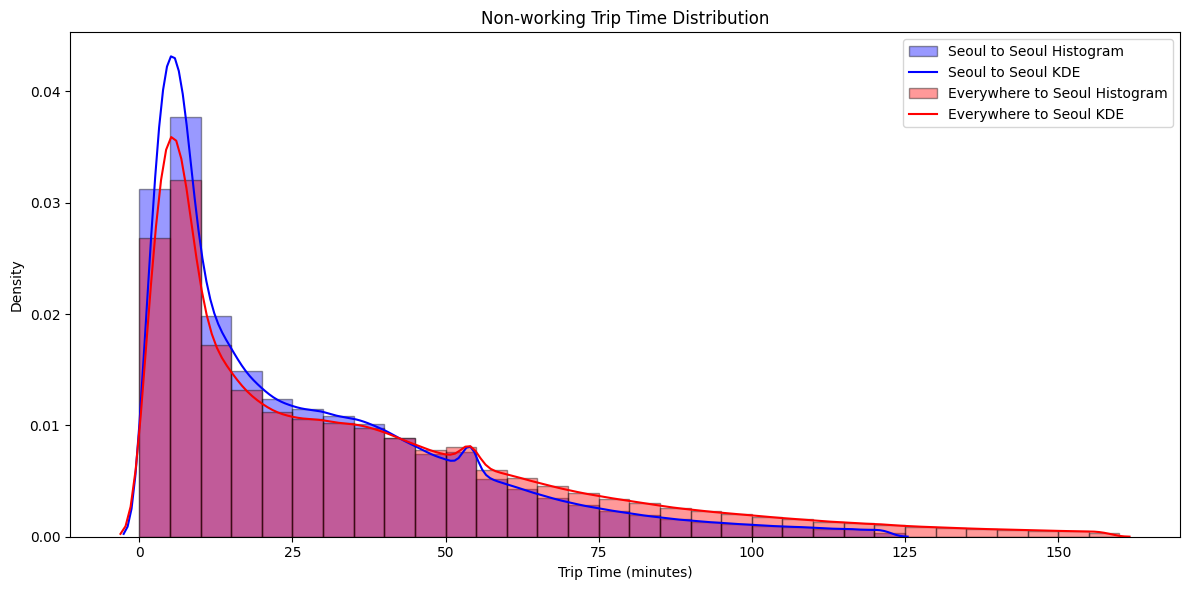

In [26]:
#@title Nonworking trip time distribution plot with trimmed sample
# Calculate bins based on the trimmed data
max_time = max(
    df_seoul_to_seoul_trimmed['MOVE_TIME'].max(),
    df_to_seoul_trimmed['MOVE_TIME'].max()
)
bins = np.arange(0, max_time + 5, 5)

plt.figure(figsize=(12, 6))

# Plot for Seoul to Seoul
plt.hist(
    df_seoul_to_seoul_trimmed['MOVE_TIME'],
    bins=bins,
    weights=df_seoul_to_seoul_trimmed['CNT'],
    alpha=0.4,
    label="Seoul to Seoul Histogram",
    color='blue',
    density=True,
    edgecolor='black'
)
sns.kdeplot(
    x=df_seoul_to_seoul_trimmed['MOVE_TIME'],
    weights=df_seoul_to_seoul_trimmed['CNT'],
    bw_adjust=1,
    label="Seoul to Seoul KDE",
    color='blue'
)

# Plot for Everywhere to Seoul
plt.hist(
    df_to_seoul_trimmed['MOVE_TIME'],
    bins=bins,
    weights=df_to_seoul_trimmed['CNT'],
    alpha=0.4,
    label="Everywhere to Seoul Histogram",
    color='red',
    density=True,
    edgecolor='black'
)
sns.kdeplot(
    x=df_to_seoul_trimmed['MOVE_TIME'],
    weights=df_to_seoul_trimmed['CNT'],
    bw_adjust=1,
    label="Everywhere to Seoul KDE",
    color='red'
)

plt.xlabel('Trip Time (minutes)')
plt.ylabel('Density')
plt.title('Non-working Trip Time Distribution') # (Trimmed Top 5%) - Weighted by CNT
plt.legend()
plt.tight_layout()
plt.show()

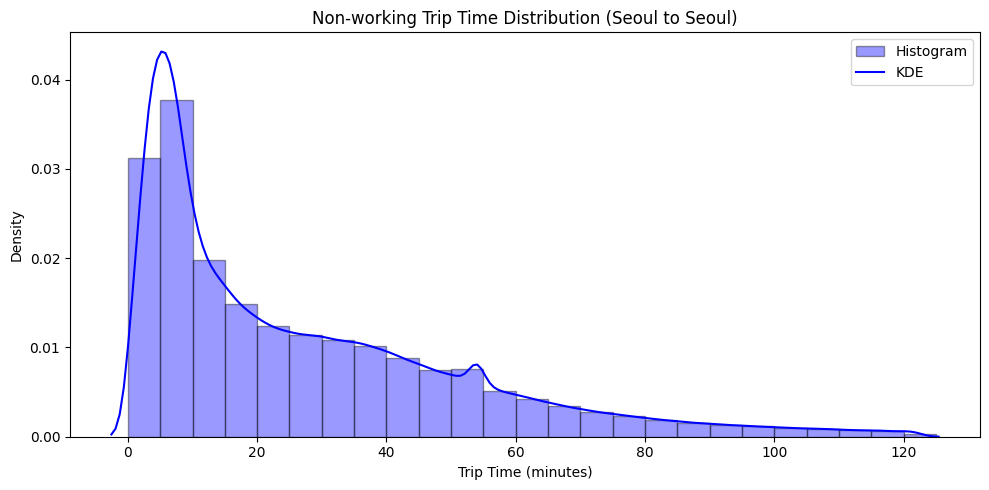

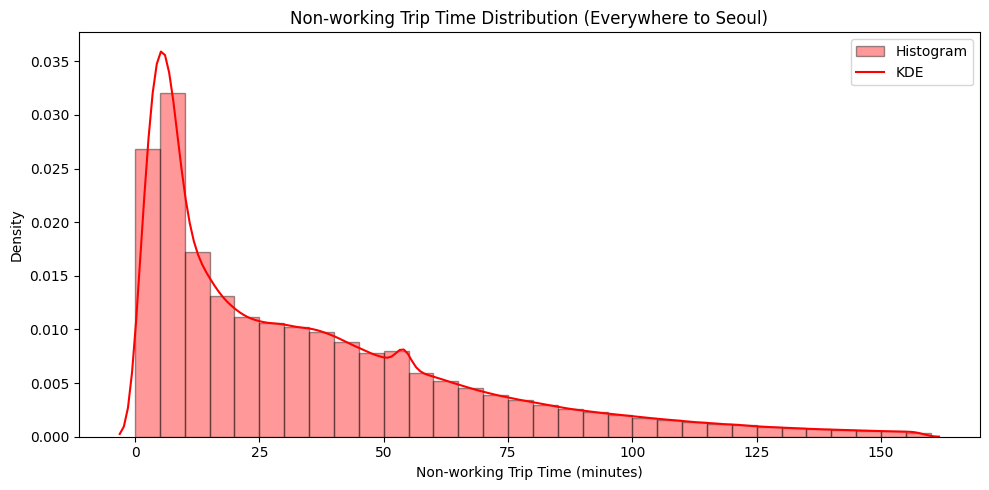

In [27]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# Calculate bin edges based on the respective trimmed data
bins_seoul_to_seoul = np.arange(
    0,
    df_seoul_to_seoul_trimmed['MOVE_TIME'].max() + 5,
    5
)
bins_to_seoul = np.arange(
    0,
    df_to_seoul_trimmed['MOVE_TIME'].max() + 5,
    5
)

# Plot for Seoul to Seoul
plt.figure(figsize=(10, 5))
plt.hist(
    df_seoul_to_seoul_trimmed['MOVE_TIME'],
    bins=bins_seoul_to_seoul,
    weights=df_seoul_to_seoul_trimmed['CNT'],
    alpha=0.4,
    color='blue',
    density=True,
    edgecolor='black',
    label='Histogram'
)
sns.kdeplot(
    x=df_seoul_to_seoul_trimmed['MOVE_TIME'],
    weights=df_seoul_to_seoul_trimmed['CNT'],
    bw_adjust=1,
    color='blue',
    label='KDE'
)
plt.xlabel('Trip Time (minutes)')
plt.ylabel('Density')
plt.title('Non-working Trip Time Distribution (Seoul to Seoul)') #\n(Trimmed Top 1%)
plt.legend()
plt.tight_layout()
plt.show()

# Plot for Everywhere to Seoul
plt.figure(figsize=(10, 5))
plt.hist(
    df_to_seoul_trimmed['MOVE_TIME'],
    bins=bins_to_seoul,
    weights=df_to_seoul_trimmed['CNT'],
    alpha=0.4,
    color='red',
    density=True,
    edgecolor='black',
    label='Histogram'
)
sns.kdeplot(
    x=df_to_seoul_trimmed['MOVE_TIME'],
    weights=df_to_seoul_trimmed['CNT'],
    bw_adjust=1,
    color='red',
    label='KDE'
)
plt.xlabel('Non-working Trip Time (minutes)')
plt.ylabel('Density')
plt.title('Non-working Trip Time Distribution (Everywhere to Seoul)') # \n(Trimmed Top 1%)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
#@title working trip
files = [
    'purpose_1_with_OD_indicators.csv'
]

# Combine files
dfs = [pd.read_csv(os.path.join(folder, f)) for f in files]
df = pd.concat(dfs, ignore_index=True)

# 1. Filter the two subsamples
df_seoul_to_seoul = df[(df['O_Seoul'] == 1) & (df['D_Seoul'] == 1)]
df_to_seoul = df[df['D_Seoul'] == 1]

def trip_time_distribution(df_sub, bins=[15, 30]):
    """
    Returns the weighted frequency distribution for given bins (in minutes).
    """
    total_trips = df_sub['CNT'].sum()
    result = {}
    prev_bin = 0
    for bin_max in bins:
        mask = (df_sub['MOVE_TIME'] > prev_bin) & (df_sub['MOVE_TIME'] <= bin_max)
        count = df_sub.loc[mask, 'CNT'].sum()
        result[f'Within {bin_max} min'] = count / total_trips * 100  # as percentage
        prev_bin = bin_max
    # Also, optionally, trips longer than last bin
    mask = df_sub['MOVE_TIME'] > bins[-1]
    count = df_sub.loc[mask, 'CNT'].sum()
    result[f'Over {bins[-1]} min'] = count / total_trips * 100
    return result

# 2. Calculate distributions
seoul_to_seoul_dist = trip_time_distribution(df_seoul_to_seoul)
to_seoul_dist = trip_time_distribution(df_to_seoul)

print("Seoul to Seoul working-trip time distribution (%):")
for k, v in seoul_to_seoul_dist.items():
    print(f"{k}: {v:.2f}%")

print("\nEverywhere to Seoul working-trip time distribution (%):")
for k, v in to_seoul_dist.items():
    print(f"{k}: {v:.2f}%")

Seoul to Seoul working-trip time distribution (%):
Within 15 min: 27.08%
Within 30 min: 19.83%
Over 30 min: 53.08%

Everywhere to Seoul working-trip time distribution (%):
Within 15 min: 20.99%
Within 30 min: 16.32%
Over 30 min: 62.69%


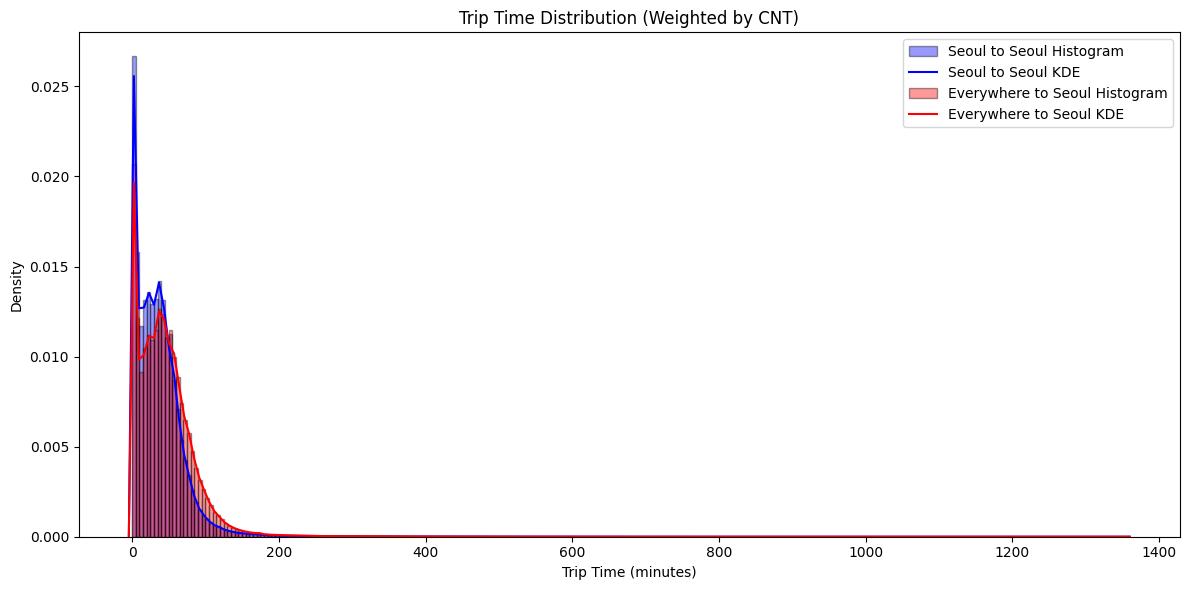

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_seoul_to_seoul = df[(df['O_Seoul'] == 1) & (df['D_Seoul'] == 1)]
df_to_seoul = df[df['D_Seoul'] == 1]

def plot_weighted_hist_kde(df_sub, label, color, bins):
    # Histogram
    plt.hist(
        df_sub['MOVE_TIME'],
        bins=bins,
        weights=df_sub['CNT'],
        alpha=0.4,
        label=f"{label} Histogram",
        color=color,
        density=True,
        edgecolor='black'
    )

    # KDE
    sns.kdeplot(
        x=df_sub['MOVE_TIME'],
        weights=df_sub['CNT'],
        bw_adjust=1,
        label=f"{label} KDE",
        color=color
    )

# Set up bins before plotting
max_time = max(df_seoul_to_seoul['MOVE_TIME'].max(), df_to_seoul['MOVE_TIME'].max())
bins = np.arange(0, max_time + 5, 5)

plt.figure(figsize=(12, 6))
plot_weighted_hist_kde(df_seoul_to_seoul, 'Seoul to Seoul', 'blue', bins)
plot_weighted_hist_kde(df_to_seoul, 'Everywhere to Seoul', 'red', bins)

plt.xlabel('Trip Time (minutes)')
plt.ylabel('Density')
plt.title('Trip Time Distribution') # (Weighted by CNT)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
max_move_time_seoul_to_seoul = df_seoul_to_seoul['MOVE_TIME'].max()
max_move_time_to_seoul = df_to_seoul['MOVE_TIME'].max()

print("Maximum MOVE_TIME in Seoul to Seoul trips:", max_move_time_seoul_to_seoul)
print("Maximum MOVE_TIME in Everywhere to Seoul trips:", max_move_time_to_seoul)

Maximum MOVE_TIME in Seoul to Seoul trips: 1355.30333333333
Maximum MOVE_TIME in Everywhere to Seoul trips: 1355.30333333333


In [32]:
# Calculate the 95th percentile for each dataset
threshold_seoul_to_seoul = df_seoul_to_seoul['MOVE_TIME'].quantile(0.95)
threshold_to_seoul = df_to_seoul['MOVE_TIME'].quantile(0.95)

# Filter out rows above the threshold
df_seoul_to_seoul_trimmed = df_seoul_to_seoul[df_seoul_to_seoul['MOVE_TIME'] <= threshold_seoul_to_seoul]
df_to_seoul_trimmed = df_to_seoul[df_to_seoul['MOVE_TIME'] <= threshold_to_seoul]

print(f"95th percentile MOVE_TIME in Seoul to Seoul: {threshold_seoul_to_seoul}")
print(f"95th percentile MOVE_TIME in Everywhere to Seoul: {threshold_to_seoul}")
print(f"Rows before trimming (Seoul-Seoul): {len(df_seoul_to_seoul)}")
print(f"Rows after trimming (Seoul-Seoul): {len(df_seoul_to_seoul_trimmed)}")
print(f"Rows before trimming (Everywhere-Seoul): {len(df_to_seoul)}")
print(f"Rows after trimming (Everywhere-Seoul): {len(df_to_seoul_trimmed)}")

95th percentile MOVE_TIME in Seoul to Seoul: 97.1933333333333
95th percentile MOVE_TIME in Everywhere to Seoul: 114.55
Rows before trimming (Seoul-Seoul): 14519951
Rows after trimming (Seoul-Seoul): 13793967
Rows before trimming (Everywhere-Seoul): 20198043
Rows after trimming (Everywhere-Seoul): 19188169


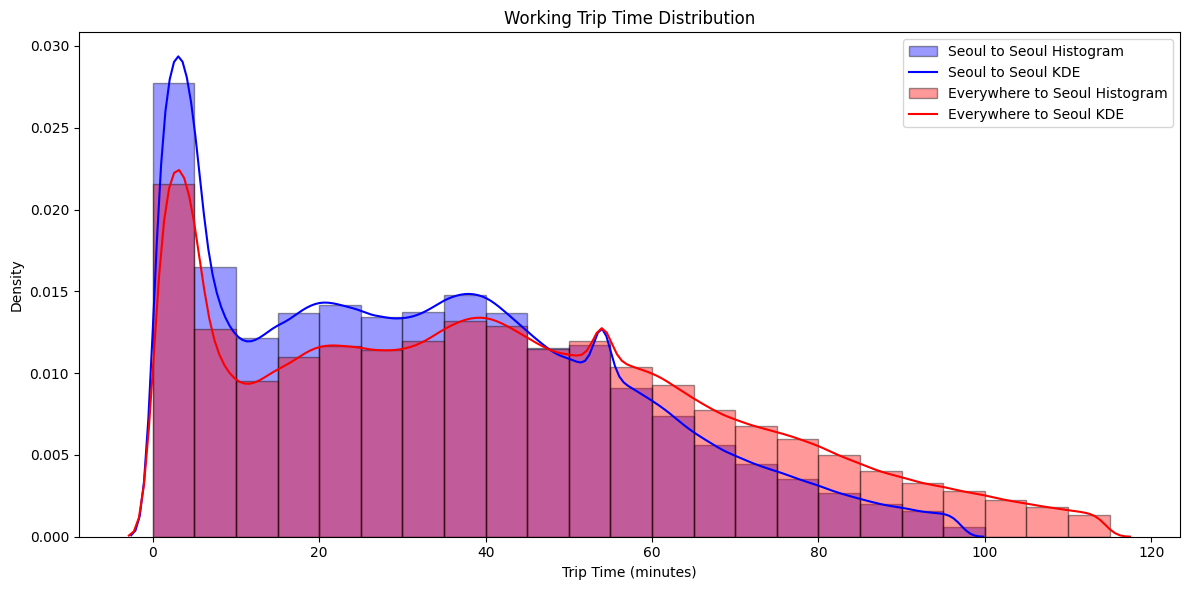

In [33]:
#@title working trip time distribution plot with trimmed sample
# Calculate bins based on the trimmed data
max_time = max(
    df_seoul_to_seoul_trimmed['MOVE_TIME'].max(),
    df_to_seoul_trimmed['MOVE_TIME'].max()
)
bins = np.arange(0, max_time + 5, 5)

plt.figure(figsize=(12, 6))

# Plot for Seoul to Seoul
plt.hist(
    df_seoul_to_seoul_trimmed['MOVE_TIME'],
    bins=bins,
    weights=df_seoul_to_seoul_trimmed['CNT'],
    alpha=0.4,
    label="Seoul to Seoul Histogram",
    color='blue',
    density=True,
    edgecolor='black'
)
sns.kdeplot(
    x=df_seoul_to_seoul_trimmed['MOVE_TIME'],
    weights=df_seoul_to_seoul_trimmed['CNT'],
    bw_adjust=1,
    label="Seoul to Seoul KDE",
    color='blue'
)

# Plot for Everywhere to Seoul
plt.hist(
    df_to_seoul_trimmed['MOVE_TIME'],
    bins=bins,
    weights=df_to_seoul_trimmed['CNT'],
    alpha=0.4,
    label="Everywhere to Seoul Histogram",
    color='red',
    density=True,
    edgecolor='black'
)
sns.kdeplot(
    x=df_to_seoul_trimmed['MOVE_TIME'],
    weights=df_to_seoul_trimmed['CNT'],
    bw_adjust=1,
    label="Everywhere to Seoul KDE",
    color='red'
)

plt.xlabel('Trip Time (minutes)')
plt.ylabel('Density')
plt.title('Working Trip Time Distribution') # (Trimmed Top 5%) - Weighted by CNT
plt.legend()
plt.tight_layout()
plt.show()

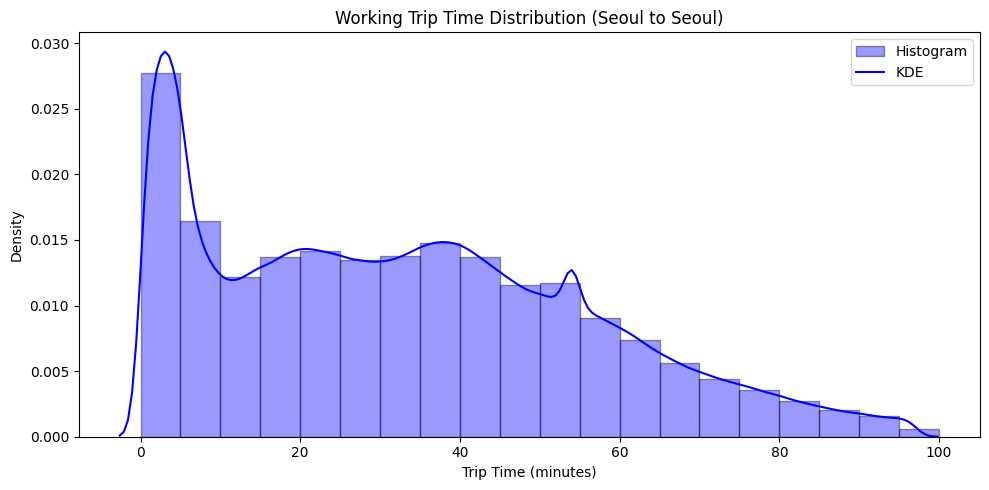

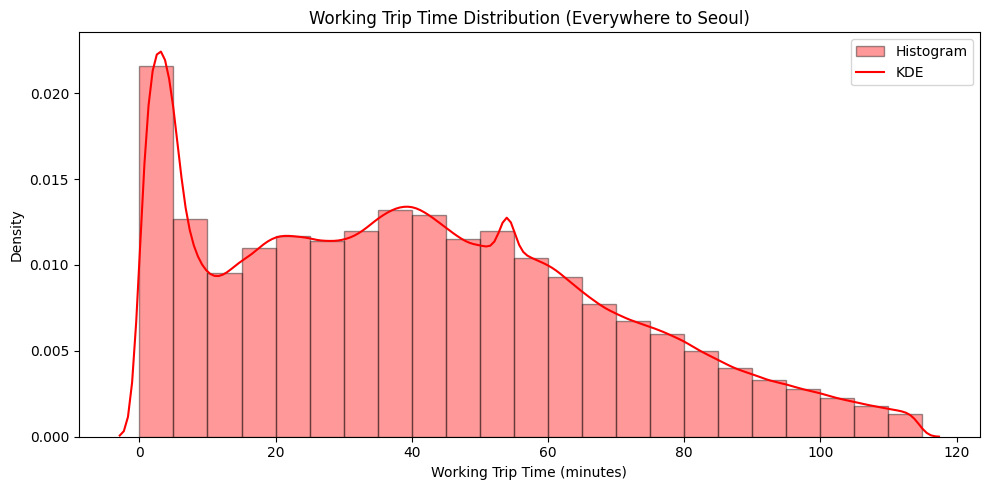

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate bin edges based on the respective trimmed data
bins_seoul_to_seoul = np.arange(
    0,
    df_seoul_to_seoul_trimmed['MOVE_TIME'].max() + 5,
    5
)
bins_to_seoul = np.arange(
    0,
    df_to_seoul_trimmed['MOVE_TIME'].max() + 5,
    5
)

# Plot for Seoul to Seoul
plt.figure(figsize=(10, 5))
plt.hist(
    df_seoul_to_seoul_trimmed['MOVE_TIME'],
    bins=bins_seoul_to_seoul,
    weights=df_seoul_to_seoul_trimmed['CNT'],
    alpha=0.4,
    color='blue',
    density=True,
    edgecolor='black',
    label='Histogram'
)
sns.kdeplot(
    x=df_seoul_to_seoul_trimmed['MOVE_TIME'],
    weights=df_seoul_to_seoul_trimmed['CNT'],
    bw_adjust=1,
    color='blue',
    label='KDE'
)
plt.xlabel('Trip Time (minutes)')
plt.ylabel('Density')
plt.title('Working Trip Time Distribution (Seoul to Seoul)') #\n(Trimmed Top 5%)
plt.legend()
plt.tight_layout()
plt.show()

# Plot for Everywhere to Seoul
plt.figure(figsize=(10, 5))
plt.hist(
    df_to_seoul_trimmed['MOVE_TIME'],
    bins=bins_to_seoul,
    weights=df_to_seoul_trimmed['CNT'],
    alpha=0.4,
    color='red',
    density=True,
    edgecolor='black',
    label='Histogram'
)
sns.kdeplot(
    x=df_to_seoul_trimmed['MOVE_TIME'],
    weights=df_to_seoul_trimmed['CNT'],
    bw_adjust=1,
    color='red',
    label='KDE'
)
plt.xlabel('Working Trip Time (minutes)')
plt.ylabel('Density')
plt.title('Working Trip Time Distribution (Everywhere to Seoul)') # \n(Trimmed Top 1%)
plt.legend()
plt.tight_layout()
plt.show()